In [6]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

# Lista de Exercício - Aula 09 - Molécula de Água e Campos de Força

1. Copie as partes do código da Aula 09 que achar apropriado e cálcule a densidade da água com 500 moléculas de água na pressão de 1 bar e para um intervalo de temperaturas entre 0°C a 5ºC com passo de 1°C e de 5°C a 100°C com passo de 10ºC. Guarde os valores numa tabela ou um arquivo no formato `.txt`. 

In [11]:
# Simulação da densidade de água a 300 K e 1 bar com 500 moléculas

# Define as variáveis do sistema molecular
N_mol = 500
L = 25 * angstrom # tamanho inicial da caixa cúbica
pressao = 1*bar # pressão em bar

# Define os valores de temperatura da simulação
Temperaturaarray = np.array([273.15,274.15,275.15,276.15,277.15,278.15,283.15,288.15,293.15,298.15,303.15,308.15,313.15,318.15,323.15,328.15,333.15,338.15,343.15,348.15,353.15,358.15,363.15,368.15,373.15])
Densidadearray = np.zeros_like(Temperaturaarray)
StdDensidadearray = np.zeros_like(Temperaturaarray)

## 1. Define a topologia da água
print("Criando a topologia da água")
mol_topology = Topology()
chain = mol_topology.addChain()
residue = mol_topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = mol_topology.addAtom("O", element_O, residue)
atom1 = mol_topology.addAtom("H", element_H, residue)
atom2 = mol_topology.addAtom("H", element_H, residue)
mol_topology.addBond(atom0, atom1)
mol_topology.addBond(atom0, atom2)

bond = 0.9572  # Å
angle = 1.82421813418 # rad (104.52° in radians)
eq_pos = (
    np.array([
    [0.0,         0.0,         0.0        ],  # O
    [ bond,       0.0,         0.0        ],  # H1
    [ bond*np.cos(angle), bond*np.sin(angle), 0.0 ],  # H2
]) * angstrom
)

## Define a topologia da caixa com moléculas de água
print("Criando a topologia da caixa com moléculas de água")
box_matrix = L * np.identity(3)
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
resname = next(mol_topology.residues()).name
for i in range(N_mol):
    chain   = topology.addChain()
    residue = topology.addResidue(resname, chain)
    atom_map = {}  
    for atom in mol_topology.atoms():
        new = topology.addAtom(atom.name, atom.element, residue)
        atom_map[atom] = new
    for bond in mol_topology.bonds():
        a1 = atom_map[bond.atom1]
        a2 = atom_map[bond.atom2]
        topology.addBond(a1, a2)

all_pos = []
for _ in range(N_mol):
    CMpos = np.random.uniform(0, L / nanometer, 3)
    coords = CMpos + eq_pos/nanometer
    all_pos.append(coords)

## Define o campo de força e o sistema
print("Escolhendo o campo de força e criando o sistema")
forcefield = ForceField('amber14/tip3p.xml')
platform = Platform.getPlatformByName('CUDA')  # ou 'CUDA' se tiver GPU



# Faz um loop para calcular a densidade em diferentes temperaturas
for i, temperatura in enumerate(Temperaturaarray):
    print(f"Temperatura: {temperatura} K")

    system = forcefield.createSystem(topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
    
    ## Define o integrador e a temperatura
    integrator = LangevinMiddleIntegrator(temperatura, 1/picosecond, 4*femtoseconds)
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(np.vstack(all_pos) * angstrom)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperatura)

    simulation.reporters = []
    simulation.reporters.append(
        StateDataReporter(
            "md_log_water.csv",
            20,
            step=True,
            time=True,
            potentialEnergy=True,
            totalEnergy=True,
            temperature=True,
            volume=True
        )
    )
    simulation.step(5000)

    ## 5. Adiciona o barostato e realiza produção NPT
    system.addForce(MonteCarloBarostat(pressao, temperatura))
    simulation.context.reinitialize(preserveState=True)
    simulation.step(70000)
    del simulation

    ## 6. Carrega os dados, analisa o volume médio e calcula a densidade
    df = pd.read_csv("md_log_water.csv")
    subsetV = df['Box Volume (nm^3)'][df['Time (ps)'] > 100.0]
    Vmean = subsetV.mean() # em nm³
    sigmaV = subsetV.std()
    nmean = (N_mol/ 6.022e23) / (Vmean * 1e-27)
    sigman = nmean * sigmaV / Vmean

    # Exporta os resultados para os arrays
    Densidadearray[i] = nmean
    StdDensidadearray[i] = sigman
    print(f"Densidade de moléculas: {nmean:.2f} ± {sigman:.2f} mol/m³")


Criando a topologia da água
Criando a topologia da caixa com moléculas de água
Escolhendo o campo de força e criando o sistema
Temperatura: 273.15 K
Densidade de moléculas: 56238.81 ± 672.52 mol/m³
Temperatura: 274.15 K
Densidade de moléculas: 56099.96 ± 733.96 mol/m³
Temperatura: 275.15 K
Densidade de moléculas: 56260.48 ± 613.17 mol/m³
Temperatura: 276.15 K
Densidade de moléculas: 56172.38 ± 588.26 mol/m³
Temperatura: 277.15 K
Densidade de moléculas: 56262.87 ± 602.39 mol/m³
Temperatura: 278.15 K
Densidade de moléculas: 56012.32 ± 694.10 mol/m³
Temperatura: 283.15 K
Densidade de moléculas: 55863.31 ± 664.41 mol/m³
Temperatura: 288.15 K
Densidade de moléculas: 55614.16 ± 756.85 mol/m³
Temperatura: 293.15 K
Densidade de moléculas: 55315.07 ± 572.81 mol/m³
Temperatura: 298.15 K
Densidade de moléculas: 55103.54 ± 626.94 mol/m³
Temperatura: 303.15 K
Densidade de moléculas: 54939.06 ± 697.45 mol/m³
Temperatura: 308.15 K
Densidade de moléculas: 54663.17 ± 658.60 mol/m³
Temperatura: 313.15 K

2. Faça um gráfico dos valores de densidade obtidos pela simulação como função da temperatura e compare com os valores tabelados do NIST que se encontram no arquivo `water_NIST.txt` na pasta `listas` do Github do curso. 

Ref: https://webbook.nist.gov/cgi/fluid.cgi?P=0.1&TLow=273.16&THigh=372.76&TInc=1&Digits=5&ID=C7732185&Action=Load&Type=IsoBar&TUnit=K&PUnit=MPa&DUnit=mol%2Fm3&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF

Text(0, 0.5, 'Densidade (mol/m³)')

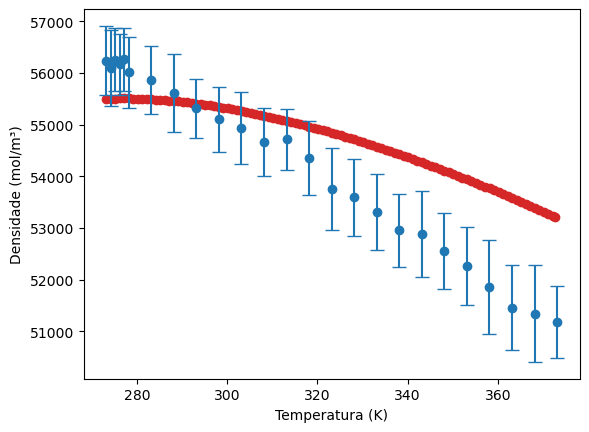

In [ ]:
df = pd.read_csv("water_NIST.txt", delim_whitespace="\t", header=0, usecols=[0,2], names=["Temperature (K)","Density (mol/m3)"])

plt.scatter(df['Temperature (K)'], df['Density (mol/m3)'], label='NIST', color='C3')
plt.errorbar(Temperaturaarray, Densidadearray, yerr=StdDensidadearray, fmt='o', ecolor='C0', capsize=5)
plt.xlabel('Temperatura (K)')
plt.ylabel('Densidade (mol/m3)')

3. Converta os dados do gráfico para densidade de massa em kg/m3.

Text(0, 0.5, 'Densidade (kg/m3)')

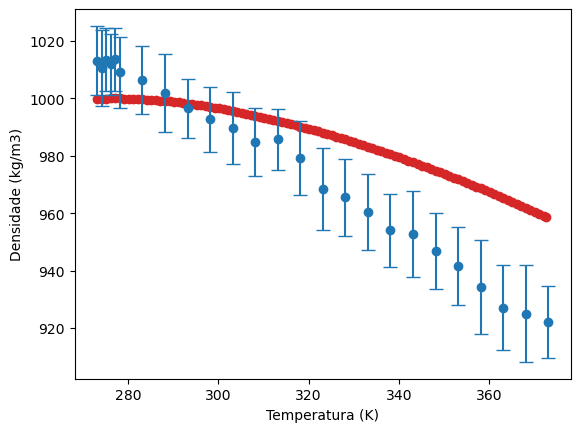

In [50]:
mmh2o = 18.01528e-3  # kg/mol

plt.scatter(df['Temperature (K)'], mmh2o*df['Density (mol/m3)'], label='NIST', color='C3')
plt.errorbar(Temperaturaarray, mmh2o*Densidadearray, yerr=mmh2o*StdDensidadearray, fmt='o', ecolor='C0', capsize=5)
plt.xlabel('Temperatura (K)')
plt.ylabel('Densidade (kg/m3)')